# Support Vector Machine - Daily Taxi Demand Prediction

In this section we predict the daily demand of taxi trips in Chicago. 
The prediciton we perform by building a model are based on data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

We split the prediction into spatial units:
- Community Areas
- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

For each of the units we perform a seperate prediction based on data we have aggregeated in our preparation.

For that we proceed as follows:

- Build SVM model with different kernels to find out which performs best. We do this based on Community areas.
- Hyperparameter tuning to find the best ones
- Build the model with found kernel and hyperparameters: make predictions for all spatial units
- Evaluation

<hr style="border: 1px solid #8888;">

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning

#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#import seaborn as sns
#import matplotlib as mlp
import matplotlib.pyplot as plt
#from datetime import datetime

from sklearn.linear_model import LinearRegression

from sklearn.svm import SVR
from sklearn import datasets

from scipy.stats import loguniform

import predictive as pred

In [2]:
# import datasets
df_24h_comar = pd.read_csv("data/datasets/df_24h_comar.csv")
df_24h_hexlow = pd.read_csv("data/datasets/df_24h_hexlow.csv")
df_24h_hexmed = pd.read_csv("data/datasets/df_24h_hexmed.csv")
df_24h_hexhig = pd.read_csv("data/datasets/df_24h_hexhig.csv")

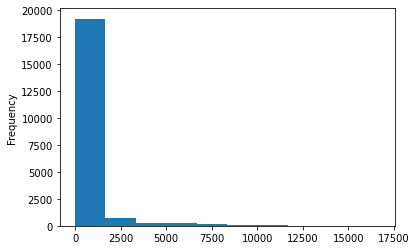

In [3]:
df_24h_comar['numOfTaxis_area'].plot.hist()
plt.show()

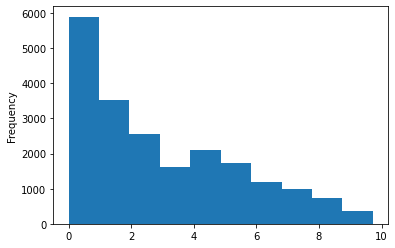

In [4]:
df_24h_comar['numOfTaxis_area'] = np.log(df_24h_comar['numOfTaxis_area'])
df_24h_comar['numOfTaxis_area'].plot.hist()
plt.show()

In [5]:
df_24h_comar.drop(columns = ['date_start'],inplace = True)
df_24h_hexlow.drop(columns = ['date_start'],inplace = True)
df_24h_hexmed.drop(columns = ['date_start'],inplace = True)
df_24h_hexhig.drop(columns = ['date_start'],inplace = True)

In [6]:
df_24h_comar = pred.dayandseas_to_int(df_24h_comar)
df_24h_hexlow = pred.dayandseas_to_int(df_24h_hexlow)
df_24h_hexmed = pred.dayandseas_to_int(df_24h_hexmed)
df_24h_hexhig = pred.dayandseas_to_int(df_24h_hexhig)

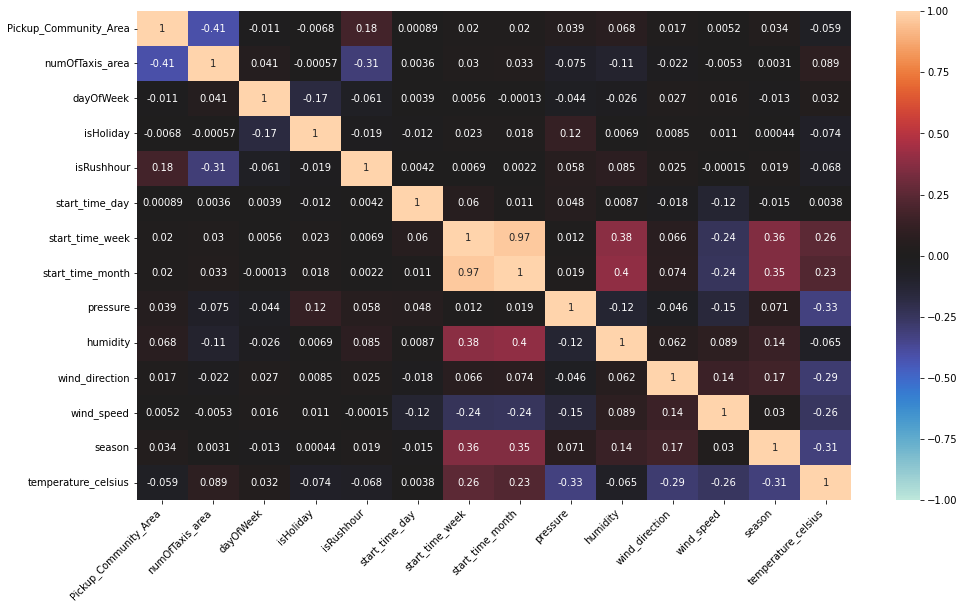

In [12]:
# correlation matrix of df_h_comar

import seaborn as sns
corr = df_24h_comar.corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

Because we are looking at the hourly demand, `start_time_hourly` and `start_stamp` is the same. So there are perfectly correlated and we are dropping `start_time_hourly`:

In [7]:
df_24h_comar.drop(columns = ['start_time_hourly'],inplace = True)

In [8]:
df_24h_comar.drop(columns = ['start_stamp'],inplace = True)

In [9]:
df_24h_comar.drop(columns = ['start_time_month'],inplace = True)

<hr style="border: 1px solid #8888;">

## Daily Demand - Community Area

In [10]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_24h_comar,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [11]:
categoric, numeric = pred.cat_and_num('Pickup_Community_Area')

### Building the model: Checking for the best kernel

#### SVR KERNEL: LINEAR

In [12]:
svr_lin = SVR(kernel = 'linear',verbose = 10,cache_size=15000, max_iter=50000)

In [13]:
pipeline = pred.pipeline_fit_predict(svr_lin, categoric, numeric, x_train_val, y_train_val, x_test, y_test,
                               df_24h_comar, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -4418.336481, rho = -2.170177
nSV = 11193, nBSV = 9678


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  0.345
MSE:  0.210
RMSE:  0.459
Accuracy: 88.16 %
R2:  96.736 %
Max Residual Error:  2.154


#### SVR KERNEL: POLYNOMIAL WITH DEGREE 2

In [14]:
svr_poly2 = SVR(kernel = 'poly',degree = 2, verbose = 10,cache_size=15000, max_iter=50000)

In [15]:
pipeline = pred.pipeline_fit_predict(svr_poly2, categoric, numeric, x_train_val, y_train_val, x_test, y_test,
                                df_24h_comar, 'numOfTaxis_area')

[LibSVM].....................*..........*
optimization finished, #iter = 31876
obj = -8072.269562, rho = -2.019864
nSV = 11295, nBSV = 9161
MODEL SCORES:
MAE:  0.368
MSE:  0.256
RMSE:  0.506
Accuracy: 87.38 %
R2:  96.030 %
Max Residual Error:  2.663


#### SVR KERNEL: POLYNOMIAL WITH DEGREE 3

In [14]:
svr_poly3 = SVR(kernel = 'poly',verbose = 10,cache_size=15000, max_iter=50000)

In [15]:
pipeline = pred.pipeline_fit_predict(svr_poly3, categoric, numeric, x_train_val, y_train_val, x_test, y_test,
                                df_24h_comar, 'numOfTaxis_area')

[LibSVM].........*
optimization finished, #iter = 9768
obj = -6235138.238645, rho = -8.566917
nSV = 14424, nBSV = 13922
MODEL SCORES:
MAE:  415.871
MSE:  2159154.850
RMSE:  1469.406
Accuracy: 3.97 %
R2: -7.867 %
Max Residual Error:  16693.147


#### SVR KERNEL: RBF

In [16]:
svr_rbf = SVR(kernel = 'rbf',verbose = 10,cache_size=15000, max_iter=50000)

In [18]:
pipeline = pred.pipeline_fit_predict(svr_rbf, categoric, numeric, x_train_val, y_train_val, x_test, y_test,
                                df_24h_comar, 'numOfTaxis_area')

[LibSVM]........
*.*.*
optimization finished, #iter = 9704
obj = -6230146.632344, rho = -10.942692
nSV = 14414, nBSV = 14105
MODEL SCORES:
MAE:  414.965
MSE:  2157754.370
RMSE:  1468.930
Accuracy: 4.18 %
R2: -7.797 %
Max Residual Error:  16685.126


<hr style="border: 0.5px solid #8888;">

### Hyperparameter Tuning for the best model

#### Sampling data for tuning:

In [6]:
x_val, y_val = pred.sampling_already_splitted(x_val, y_val, 'numOfTaxis_area', 5000)

In [28]:
# creating the ranges for model parameter to use in find_best_hyperparameters

model_para = {'model__C':loguniform(1e-1, 1e2),        
                'model__epsilon':loguniform(1e-1, 1e2)}               

In [29]:
svr_lin = SVR(kernel = 'linear',cache_size=15000, max_iter=50000)

In [30]:
pipeline = pred.pipeline_for_prediction(categoric, numeric, svr_lin)

In [31]:
pred.find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_absolute_error', verbose=10)

Running grid search for the model based on neg_mean_absolute_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-492.141 total time=   0.5s
[CV 2/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 2/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-477.283 total time=   0.4s
[CV 3/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 3/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-409.297 total time=   0.4s
[CV 4/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 4/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-495.061 total time=   0.4s
[CV 5/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 5/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-493.719 total time=   0.4s
[CV 6/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-348.268 total time=   0.7s
[CV 2/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-329.818 total time=   0.7s
[CV 3/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-268.340 total time=   0.7s
[CV 4/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-353.340 total time=   0.8s
[CV 5/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-339.927 total time=   0.8s
[CV 6/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-349.333 total time=   0.8s
[CV 7/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-328.382 total time=   0.7s
[CV 8/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-268.265 total time=   0.7s
[CV 9/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-353.654 total time=   0.7s
[CV 10/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-340.383 total time=   0.7s
[CV 11/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-348.296 total time=   0.8s
[CV 12/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-330.781 total time=   0.7s
[CV 13/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-267.893 total time=   0.7s
[CV 14/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-353.751 total time=   0.7s
[CV 15/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-339.361 total time=   0.7s
[CV 1/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 1/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-486.386 total time=   0.8s
[CV 2/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 2/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-471.086 total time=   0.8s
[CV 3/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 3/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-401.208 total time=   0.8s
[CV 4/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 4/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-487.171 total time=   0.7s
[CV 5/15; 3/50] START model__C=0.2938027938703535, model__epsilo

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-411.905 total time=   0.6s
[CV 2/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-397.458 total time=   0.6s
[CV 3/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-329.993 total time=   0.6s
[CV 4/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-415.175 total time=   0.6s
[CV 5/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-411.480 total time=   0.6s
[CV 6/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-412.544 total time=   0.6s
[CV 7/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-397.436 total time=   0.6s
[CV 8/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-329.197 total time=   0.6s
[CV 9/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-415.543 total time=   0.6s
[CV 10/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-411.818 total time=   0.6s
[CV 11/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-412.346 total time=   0.6s
[CV 12/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-397.999 total time=   0.6s
[CV 13/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-329.904 total time=   0.6s
[CV 14/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-415.699 total time=   0.6s
[CV 15/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-410.639 total time=   0.6s
[CV 1/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 1/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-515.387 total time=   0.5s
[CV 2/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 2/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-500.771 total time=   0.5s
[CV 3/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 3/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-431.729 total time=   0.5s
[CV 4/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 4/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-517.769 total time=   0.5s
[CV 5/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.2324508558868

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-286.384 total time=   1.6s
[CV 2/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-271.295 total time=   1.6s
[CV 3/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-213.171 total time=   1.6s
[CV 4/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-291.994 total time=   1.6s
[CV 5/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-273.809 total time=   1.7s
[CV 6/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-287.080 total time=   1.6s
[CV 7/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-269.054 total time=   1.7s
[CV 8/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-213.482 total time=   1.7s
[CV 9/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-292.456 total time=   1.7s
[CV 10/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-273.628 total time=   1.7s
[CV 11/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-287.137 total time=   1.7s
[CV 12/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-270.696 total time=   1.7s
[CV 13/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-212.968 total time=   1.7s
[CV 14/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-292.536 total time=   1.7s
[CV 15/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-272.855 total time=   1.7s
[CV 1/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 1/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-484.816 total time=   0.7s
[CV 2/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 2/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-469.531 total time=   0.7s
[CV 3/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 3/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-399.734 total time=   0.8s
[CV 4/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 4/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-485.661 total time=   0.7s
[CV 5/15; 8/50] START model__C=0.3511356313970407, model

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-454.161 total time=   0.8s
[CV 2/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-439.394 total time=   0.8s
[CV 3/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-370.270 total time=   0.8s
[CV 4/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-455.735 total time=   0.8s
[CV 5/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-455.159 total time=   0.8s
[CV 6/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-453.956 total time=   0.8s
[CV 7/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299
[CV 7/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-439.375 total time=   0.8s
[CV 8/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-370.287 total time=   0.8s
[CV 9/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-455.924 total time=   0.9s
[CV 10/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-455.449 total time=   0.9s
[CV 11/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-453.976 total time=   0.9s
[CV 12/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-439.149 total time=   0.8s
[CV 13/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-370.752 total time=   0.8s
[CV 14/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-455.800 total time=   0.8s
[CV 15/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-454.969 total time=   0.8s
[CV 1/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-405.015 total time=   1.1s
[CV 2/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-390.379 total time=   1.1s
[CV 3/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-323.021 total time=   1.1s
[CV 4/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-408.443 total time=   1.1s
[CV 5/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-404.360 total time=   1.1s
[CV 6/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-405.536 total time=   1.1s
[CV 7/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-390.229 total time=   1.1s
[CV 8/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-322.372 total time=   1.1s
[CV 9/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-408.542 total time=   1.1s
[CV 10/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-404.637 total time=   1.1s
[CV 11/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-405.440 total time=   1.1s
[CV 12/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-390.575 total time=   1.1s
[CV 13/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-322.871 total time=   1.1s
[CV 14/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-408.863 total time=   1.1s
[CV 15/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-403.833 total time=   1.1s
[CV 1/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 1/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-475.217 total time=   0.7s
[CV 2/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 2/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-460.062 total time=   0.7s
[CV 3/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 3/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-390.643 total time=   0.7s
[CV 4/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 4/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-476.315 total time=   0.7s
[CV 5/15; 12/50] START model__C=0.7523742884534856, model

[CV 10/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-484.414 total time=   0.7s
[CV 11/15; 14/50] START model__C=0.3972110727381912, model__epsilon=3.4890188454913864
[CV 11/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-483.833 total time=   0.7s
[CV 12/15; 14/50] START model__C=0.3972110727381912, model__epsilon=3.4890188454913864
[CV 12/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-468.625 total time=   0.7s
[CV 13/15; 14/50] START model__C=0.3972110727381912, model__epsilon=3.4890188454913864
[CV 13/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-399.012 total time=   0.7s
[CV 14/15; 14/50] START model__C=0.3972110727381912, model__epsilon=3.4890188454913864
[CV 14/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-484.532 total time=   0.7s
[CV 15/15; 14/50] START model__C=0.397211072738

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-412.154 total time=   1.1s
[CV 2/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-397.565 total time=   1.1s
[CV 3/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-329.919 total time=   1.0s
[CV 4/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-415.172 total time=   1.1s
[CV 5/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-412.118 total time=   1.0s
[CV 6/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-412.365 total time=   1.1s
[CV 7/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-397.561 total time=   1.0s
[CV 8/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-329.353 total time=   1.1s
[CV 9/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-415.640 total time=   1.0s
[CV 10/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-412.203 total time=   1.0s
[CV 11/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-412.390 total time=   1.0s
[CV 12/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-397.814 total time=   1.0s
[CV 13/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-329.925 total time=   1.1s
[CV 14/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-415.711 total time=   1.0s
[CV 15/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-411.536 total time=   1.1s
[CV 1/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-406.680 total time=   1.1s
[CV 2/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-392.035 total time=   1.1s
[CV 3/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-324.672 total time=   1.0s
[CV 4/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-409.987 total time=   1.1s
[CV 5/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-406.175 total time=   1.1s
[CV 6/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-407.124 total time=   1.1s
[CV 7/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-391.916 total time=   1.1s
[CV 8/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-323.922 total time=   1.1s
[CV 9/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-410.264 total time=   1.1s
[CV 10/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-406.348 total time=   1.0s
[CV 11/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-407.050 total time=   1.1s
[CV 12/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-392.293 total time=   1.0s
[CV 13/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-324.398 total time=   1.1s
[CV 14/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-410.480 total time=   1.1s
[CV 15/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-405.599 total time=   1.1s
[CV 1/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 1/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-510.055 total time=   0.5s
[CV 2/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 2/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-495.426 total time=   0.5s
[CV 3/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 3/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-426.232 total time=   0.5s
[CV 4/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 4/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-512.293 total time=   0.5s
[CV 5/15; 17/50] START model__C=0.15673095467235415, mo

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-187.759 total time=   0.6s
[CV 2/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-192.923 total time=   0.6s
[CV 3/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-148.800 total time=   0.6s
[CV 4/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-188.980 total time=   0.6s
[CV 5/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-188.477 total time=   0.6s
[CV 6/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-188.669 total time=   0.6s
[CV 7/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-191.871 total time=   0.6s
[CV 8/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-148.748 total time=   0.6s
[CV 9/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-188.246 total time=   0.6s
[CV 10/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-188.608 total time=   0.6s
[CV 11/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-189.307 total time=   0.6s
[CV 12/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-192.743 total time=   0.6s
[CV 13/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-148.679 total time=   0.6s
[CV 14/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-189.547 total time=   0.6s
[CV 15/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-187.350 total time=   0.7s
[CV 1/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 1/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-473.762 total time=   0.8s
[CV 2/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 2/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-458.627 total time=   0.8s
[CV 3/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 3/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-389.218 total time=   0.8s
[CV 4/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 4/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-474.906 total time=   0.8s
[CV 5/15; 19/50] START model__C=0.8200518402245829, mode

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-372.956 total time=   0.9s
[CV 2/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-357.469 total time=   0.9s
[CV 3/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-292.140 total time=   0.9s
[CV 4/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-376.579 total time=   0.9s
[CV 5/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-368.730 total time=   0.9s
[CV 6/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-373.695 total time=   0.9s
[CV 7/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-356.712 total time=   0.9s
[CV 8/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-291.727 total time=   0.9s
[CV 9/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-376.895 total time=   0.9s
[CV 10/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-369.182 total time=   0.9s
[CV 11/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-373.317 total time=   0.9s
[CV 12/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-357.971 total time=   0.9s
[CV 13/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-291.921 total time=   0.9s
[CV 14/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-376.804 total time=   0.9s
[CV 15/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-368.376 total time=   0.9s
[CV 1/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 1/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-488.152 total time=   0.7s
[CV 2/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 2/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-472.821 total time=   0.7s
[CV 3/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 3/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-403.025 total time=   0.7s
[CV 4/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 4/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-489.014 total time=   0.7s
[CV 5/15; 21/50] START model__C=0.2323350351539011, mod

[CV 10/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-480.838 total time=   0.6s
[CV 11/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 11/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-480.139 total time=   0.6s
[CV 12/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 12/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-465.061 total time=   0.6s
[CV 13/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 13/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-395.374 total time=   0.6s
[CV 14/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 14/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-480.744 total time=   0.6s
[CV 15/15; 23/50] START model__C=0.5975027999960293, mod

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-426.519 total time=   1.0s
[CV 2/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-411.850 total time=   1.0s
[CV 3/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-344.115 total time=   1.0s
[CV 4/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-429.234 total time=   1.0s
[CV 5/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-427.296 total time=   1.0s
[CV 6/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-426.421 total time=   1.0s
[CV 7/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-412.277 total time=   1.0s
[CV 8/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-343.570 total time=   0.9s
[CV 9/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-429.545 total time=   1.0s
[CV 10/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-427.346 total time=   1.0s
[CV 11/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-426.491 total time=   1.0s
[CV 12/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-411.904 total time=   1.0s
[CV 13/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-344.026 total time=   1.0s
[CV 14/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-429.405 total time=   1.0s
[CV 15/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-427.023 total time=   1.0s
[CV 1/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-184.428 total time=   0.7s
[CV 2/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-189.302 total time=   0.7s
[CV 3/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-146.705 total time=   0.7s
[CV 4/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-185.626 total time=   0.7s
[CV 5/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-185.931 total time=   0.7s
[CV 6/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-185.403 total time=   0.7s
[CV 7/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-188.059 total time=   0.7s
[CV 8/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-146.502 total time=   0.7s
[CV 9/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-185.437 total time=   0.7s
[CV 10/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-186.026 total time=   0.7s
[CV 11/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-185.925 total time=   0.7s
[CV 12/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-189.130 total time=   0.7s
[CV 13/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-146.596 total time=   0.7s
[CV 14/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-186.266 total time=   0.7s
[CV 15/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-184.681 total time=   0.7s
[CV 1/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-216.929 total time=   0.5s
[CV 2/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-213.668 total time=   0.5s
[CV 3/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-163.868 total time=   0.5s
[CV 4/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-216.273 total time=   0.5s
[CV 5/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-208.752 total time=   0.5s
[CV 6/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-218.056 total time=   0.5s
[CV 7/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-213.586 total time=   0.5s
[CV 8/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-163.963 total time=   0.5s
[CV 9/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-216.221 total time=   0.5s
[CV 10/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-209.279 total time=   0.5s
[CV 11/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-219.149 total time=   0.5s
[CV 12/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-214.288 total time=   0.5s
[CV 13/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-163.384 total time=   0.5s
[CV 14/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-217.359 total time=   0.5s
[CV 15/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-207.498 total time=   0.5s
[CV 1/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-432.854 total time=   0.5s
[CV 2/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-418.397 total time=   0.5s
[CV 3/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-351.920 total time=   0.5s
[CV 4/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-437.491 total time=   0.5s
[CV 5/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-432.265 total time=   0.5s
[CV 6/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-433.896 total time=   0.5s
[CV 7/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-419.252 total time=   0.5s
[CV 8/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-350.740 total time=   0.5s
[CV 9/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-437.902 total time=   0.5s
[CV 10/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-431.891 total time=   0.5s
[CV 11/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-434.118 total time=   0.5s
[CV 12/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-419.427 total time=   0.5s
[CV 13/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-351.113 total time=   0.5s
[CV 14/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-436.028 total time=   0.5s
[CV 15/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-432.117 total time=   0.5s
[CV 1/15; 29/50] START model__C=0.18427970406864538, model__epsilon=0.3872118032174582
[CV 1/15; 29/50] END model__C=0.18427970406864538, model__epsilon=0.3872118032174582;, score=-489.511 total time=   0.7s
[CV 2/15; 29/50] START model__C=0.18427970406864538, model__epsilon=0.3872118032174582
[CV 2/15; 29/50] END model__C=0.18427970406864538, model__epsilon=0.3872118032174582;, score=-474.195 total time=   0.7s
[CV 3/15; 29/50] START model__C=0.18427970406864538, model__epsilon=0.3872118032174582
[CV 3/15; 29/50] END model__C=0.18427970406864538, model__epsilon=0.3872118032174582;, score=-404.332 total time=   0.7s
[CV 4/15; 29/50] START model__C=0.18427970406864538, model__epsilon=0.3872118032174582
[CV 4/15; 29/50] END model__C=0.18427970406864538, model__epsilon=0.3872118032174582;, score=-490.258 total time=   0.7s
[CV 5/15; 29/50] START model__C=0.18427970406864

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-463.328 total time=   0.8s
[CV 5/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174
[CV 5/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-462.854 total time=   0.8s
[CV 6/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-461.865 total time=   0.8s
[CV 7/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174
[CV 7/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-447.229 total time=   0.8s
[CV 8/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174
[CV 8/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-377.705 total time=   0.8s
[CV 9/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174
[CV 9/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-463.376 total time=   0.9s
[CV 10/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174
[CV 10/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-463.107 total time=   0.8s
[CV 11/15; 31/50] START model__C=1.4656553886225332, m

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-461.761 total time=   0.8s
[CV 12/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174
[CV 12/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-446.955 total time=   0.8s
[CV 13/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174
[CV 13/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-378.241 total time=   0.8s
[CV 14/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174
[CV 14/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-463.417 total time=   0.8s
[CV 15/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174
[CV 15/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-462.696 total time=   0.8s
[CV 1/15; 32/50] START model__C=30.634622106220

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-287.994 total time=   1.4s
[CV 2/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-273.622 total time=   1.4s
[CV 3/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-214.347 total time=   1.5s
[CV 4/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-295.007 total time=   1.4s
[CV 5/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-276.773 total time=   1.5s
[CV 6/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-288.956 total time=   1.4s
[CV 7/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-271.363 total time=   1.5s
[CV 8/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-214.670 total time=   1.4s
[CV 9/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-295.472 total time=   1.4s
[CV 10/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-276.718 total time=   1.4s
[CV 11/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-288.939 total time=   1.4s
[CV 12/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-273.428 total time=   1.4s
[CV 13/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-214.276 total time=   1.4s
[CV 14/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-295.541 total time=   1.4s
[CV 15/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-276.061 total time=   1.4s
[CV 1/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 1/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-476.821 total time=   0.6s
[CV 2/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 2/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-461.545 total time=   0.6s
[CV 3/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 3/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-392.186 total time=   0.7s
[CV 4/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 4/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-477.964 total time=   0.7s
[CV 5/15; 33/50] START model__C=0.6963114377829286, model__epsi

[CV 10/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-520.410 total time=   0.4s
[CV 11/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 11/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-519.209 total time=   0.4s
[CV 12/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 12/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-504.666 total time=   0.4s
[CV 13/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 13/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-435.569 total time=   0.4s
[CV 14/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 14/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-521.474 total time=   0.4s
[CV 15/15; 35/50] START model__C=0.167360101678

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-324.511 total time=   1.5s
[CV 2/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-307.162 total time=   1.5s
[CV 3/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-246.814 total time=   1.5s
[CV 4/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-331.185 total time=   1.4s
[CV 5/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-314.320 total time=   1.5s
[CV 6/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-325.677 total time=   1.5s
[CV 7/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-305.260 total time=   1.5s
[CV 8/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-246.701 total time=   1.5s
[CV 9/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-331.507 total time=   1.5s
[CV 10/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-314.558 total time=   1.5s
[CV 11/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-324.987 total time=   1.5s
[CV 12/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-307.682 total time=   1.5s
[CV 13/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-246.222 total time=   1.5s
[CV 14/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-331.458 total time=   1.5s
[CV 15/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-314.028 total time=   1.5s
[CV 1/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 1/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-496.578 total time=   0.5s
[CV 2/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 2/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-481.403 total time=   0.5s
[CV 3/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 3/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-411.744 total time=   0.5s
[CV 4/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 4/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-497.925 total time=   0.5s
[CV 5/15; 37/50] START model__C=0.10388823104027935, model__e

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-364.315 total time=   0.6s
[CV 2/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-346.834 total time=   0.6s
[CV 3/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-283.827 total time=   0.6s
[CV 4/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-368.828 total time=   0.6s
[CV 5/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-357.931 total time=   0.6s
[CV 6/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-365.222 total time=   0.6s
[CV 7/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-346.058 total time=   0.6s
[CV 8/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-283.376 total time=   0.6s
[CV 9/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-369.157 total time=   0.6s
[CV 10/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-358.589 total time=   0.6s
[CV 11/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-364.940 total time=   0.6s
[CV 12/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-347.676 total time=   0.6s
[CV 13/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-283.331 total time=   0.6s
[CV 14/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-369.248 total time=   0.6s
[CV 15/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-357.405 total time=   0.6s
[CV 1/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-325.286 total time=   1.5s
[CV 2/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-307.700 total time=   1.5s
[CV 3/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-247.377 total time=   1.5s
[CV 4/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-331.745 total time=   1.5s
[CV 5/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-314.718 total time=   1.5s
[CV 6/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-326.364 total time=   1.5s
[CV 7/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-305.813 total time=   1.5s
[CV 8/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-247.264 total time=   1.5s
[CV 9/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-332.060 total time=   1.5s
[CV 10/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-315.148 total time=   1.5s
[CV 11/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-325.600 total time=   1.5s
[CV 12/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-308.218 total time=   1.5s
[CV 13/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-246.825 total time=   1.5s
[CV 14/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-332.014 total time=   1.5s
[CV 15/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-314.594 total time=   1.5s
[CV 1/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677
[CV 1/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-466.655 total time=   0.8s
[CV 2/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677
[CV 2/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-451.651 total time=   0.8s
[CV 3/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677
[CV 3/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-382.287 total time=   0.8s
[CV 4/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677
[CV 4/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-467.935 total time=   0.8s
[CV 5/15; 40/50] START model__C=1.1895896737553

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-467.694 total time=   0.8s
[CV 11/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677
[CV 11/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-466.436 total time=   0.8s
[CV 12/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677
[CV 12/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-451.757 total time=   0.8s
[CV 13/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677
[CV 13/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-382.610 total time=   0.8s
[CV 14/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677
[CV 14/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-468.002 total time=   0.8s
[CV 15/15; 40/50] START model__C=1.189

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-264.942 total time=   0.9s
[CV 2/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-254.635 total time=   0.9s
[CV 3/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-194.898 total time=   0.9s
[CV 4/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-271.316 total time=   0.9s
[CV 5/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-253.531 total time=   0.9s
[CV 6/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-266.050 total time=   0.9s
[CV 7/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-252.497 total time=   0.9s
[CV 8/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-195.500 total time=   0.9s
[CV 9/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-271.665 total time=   0.9s
[CV 10/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-253.459 total time=   0.9s
[CV 11/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-266.121 total time=   0.9s
[CV 12/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-254.328 total time=   0.9s
[CV 13/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-195.116 total time=   0.9s
[CV 14/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-271.837 total time=   0.9s
[CV 15/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-252.472 total time=   0.9s
[CV 1/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 1/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-470.439 total time=   0.8s
[CV 2/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 2/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-455.415 total time=   0.8s
[CV 3/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 3/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-386.022 total time=   0.8s
[CV 4/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 4/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-471.734 total time=   0.8s
[CV 5/15; 42/50] START model__C=0.9833181933644887,

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-350.300 total time=   0.7s
[CV 2/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-331.537 total time=   0.7s
[CV 3/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-269.689 total time=   0.7s
[CV 4/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-355.096 total time=   0.7s
[CV 5/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-341.701 total time=   0.7s
[CV 6/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-351.140 total time=   0.7s
[CV 7/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-330.284 total time=   0.7s
[CV 8/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-269.583 total time=   0.7s
[CV 9/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-355.362 total time=   0.7s
[CV 10/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-341.993 total time=   0.7s
[CV 11/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-350.370 total time=   0.7s
[CV 12/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-332.422 total time=   0.7s
[CV 13/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-269.155 total time=   0.7s
[CV 14/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-355.499 total time=   0.7s
[CV 15/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-340.870 total time=   0.7s
[CV 1/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-247.816 total time=   1.3s
[CV 2/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-236.014 total time=   1.3s
[CV 3/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-178.282 total time=   1.3s
[CV 4/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-253.098 total time=   1.3s
[CV 5/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-235.628 total time=   1.3s
[CV 6/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-249.065 total time=   1.3s
[CV 7/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-233.538 total time=   1.3s
[CV 8/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-178.953 total time=   1.3s
[CV 9/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-253.488 total time=   1.3s
[CV 10/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-235.523 total time=   1.4s
[CV 11/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-249.061 total time=   1.4s
[CV 12/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-235.375 total time=   1.4s
[CV 13/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-178.547 total time=   1.3s
[CV 14/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-253.642 total time=   1.3s
[CV 15/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-234.869 total time=   1.3s
[CV 1/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 1/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-489.320 total time=   0.6s
[CV 2/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 2/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-474.011 total time=   0.6s
[CV 3/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 3/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-404.359 total time=   0.6s
[CV 4/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 4/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-490.593 total time=   0.6s
[CV 5/15; 46/50] START model__C=0.228445568500205

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-332.422 total time=   0.8s
[CV 2/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-314.577 total time=   0.8s
[CV 3/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-253.759 total time=   0.8s
[CV 4/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-338.193 total time=   0.8s
[CV 5/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-320.845 total time=   0.8s
[CV 6/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-333.530 total time=   0.8s
[CV 7/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-312.652 total time=   0.8s
[CV 8/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-253.588 total time=   0.8s
[CV 9/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-338.560 total time=   0.8s
[CV 10/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-321.322 total time=   0.8s
[CV 11/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-332.911 total time=   0.8s
[CV 12/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-315.387 total time=   0.8s
[CV 13/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-253.232 total time=   0.8s
[CV 14/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-338.604 total time=   0.8s
[CV 15/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-320.584 total time=   0.8s
[CV 1/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-325.726 total time=   1.0s
[CV 2/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-308.104 total time=   1.0s
[CV 3/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-247.766 total time=   1.0s
[CV 4/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-332.060 total time=   1.0s
[CV 5/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-315.121 total time=   1.0s
[CV 6/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-326.886 total time=   1.0s
[CV 7/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-306.119 total time=   1.0s
[CV 8/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-247.508 total time=   1.0s
[CV 9/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-332.406 total time=   1.0s
[CV 10/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-315.413 total time=   1.0s
[CV 11/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-326.273 total time=   1.0s
[CV 12/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-308.581 total time=   1.0s
[CV 13/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-247.196 total time=   1.0s
[CV 14/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-332.419 total time=   1.0s
[CV 15/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-314.624 total time=   1.0s
[CV 1/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-433.355 total time=   0.8s
[CV 2/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-418.551 total time=   0.8s
[CV 3/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-350.802 total time=   0.8s
[CV 4/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-435.859 total time=   0.8s
[CV 5/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-434.193 total time=   0.8s
[CV 6/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-433.004 total time=   0.8s
[CV 7/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-418.787 total time=   0.8s
[CV 8/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-350.334 total time=   0.8s
[CV 9/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-436.288 total time=   0.8s
[CV 10/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-434.655 total time=   0.8s
[CV 11/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-433.217 total time=   0.8s
[CV 12/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-418.761 total time=   0.8s
[CV 13/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-350.659 total time=   0.8s
[CV 14/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-436.142 total time=   0.8s
[CV 15/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-434.089 total time=   0.8s
[CV 1/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 1/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-491.475 total time=   0.7s
[CV 2/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 2/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-476.186 total time=   0.7s
[CV 3/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 3/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-406.326 total time=   0.8s
[CV 4/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 4/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-492.231 total time=   0.8s
[CV 5/15; 50/50] START model__C=0.119194

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [32]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon =21.154290797261208, C= 81.05016126411583,verbose = 10)

In [33]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                     df_24h_comar, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -132407772.396844, rho = -271.567288
nSV = 3938, nBSV = 3222


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  135.378
MSE:  282604.194
RMSE:  531.605
Accuracy: 68.74 %
R2:  85.882 %
Max Residual Error:  9978.029


<hr style="border: 0.5px solid #8888;">


## Daily Demand - hexagon low resolution 

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_24h_hexlow,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_low_res')

In [60]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [61]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train_val, y_train_val, x_test, y_test,
                                      df_24h_hexlow, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -106216334.908176, rho = -31.404760
nSV = 45998, nBSV = 34352


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  49.649
MSE:  19335.192
RMSE:  139.051
Accuracy: 42.61 %
R2:  59.394 %
Max Residual Error:  1997.387


<hr style="border: 0.5px solid #8888;">


## Daily Demand - hexagon medium resolution

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_24h_hexmed,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_medium_res')

In [72]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [73]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                df_24h_hexmed, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -71769692.922822, rho = -9.900635
nSV = 53540, nBSV = 36094


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  21.106
MSE:  3232.545
RMSE:  56.855
Accuracy: 34.96 %
R2:  60.551 %
Max Residual Error:  1298.962


<hr style="border: 0.5px solid #8888;">


## Daily Demand - hexagon high resolution

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_24h_hexhig,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_high_res')

In [78]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [79]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                df_24h_hexhig, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -54172541.831035, rho = -1.700378
nSV = 59016, nBSV = 39918


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  13.751
MSE:  628.844
RMSE:  25.077
Accuracy: 16.63 %
R2:  45.458 %
Max Residual Error:  599.243
